,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


,model,rmse,mae,r2
0,LinearRegression,67.443316,52.561918,0.875247
1,RandomForest,73.588714,55.208734,0.851476


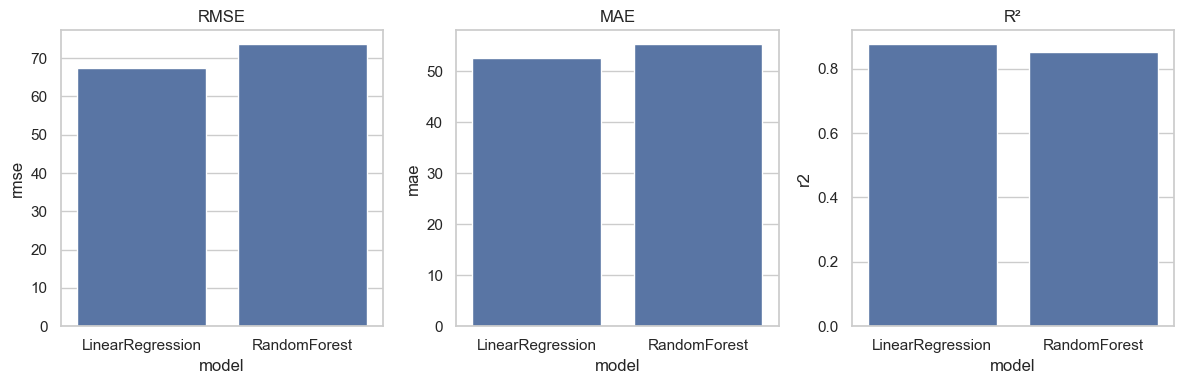

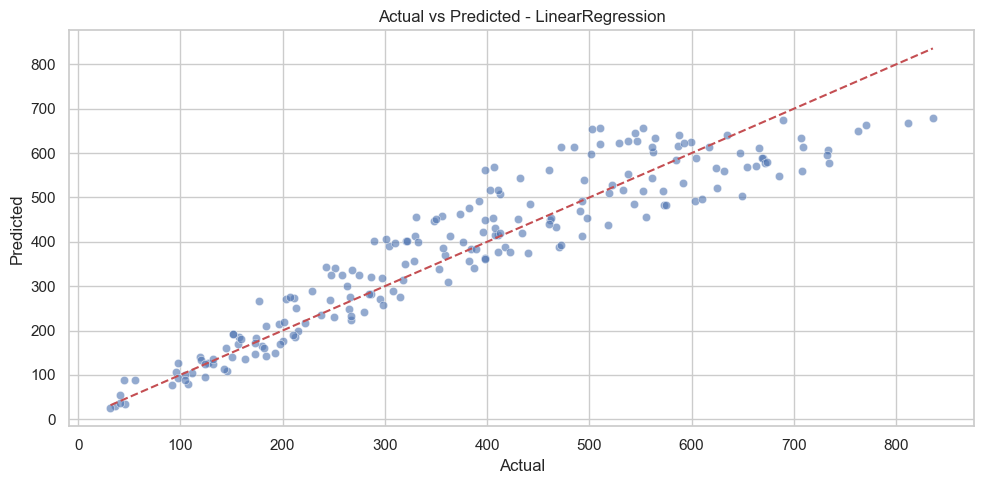

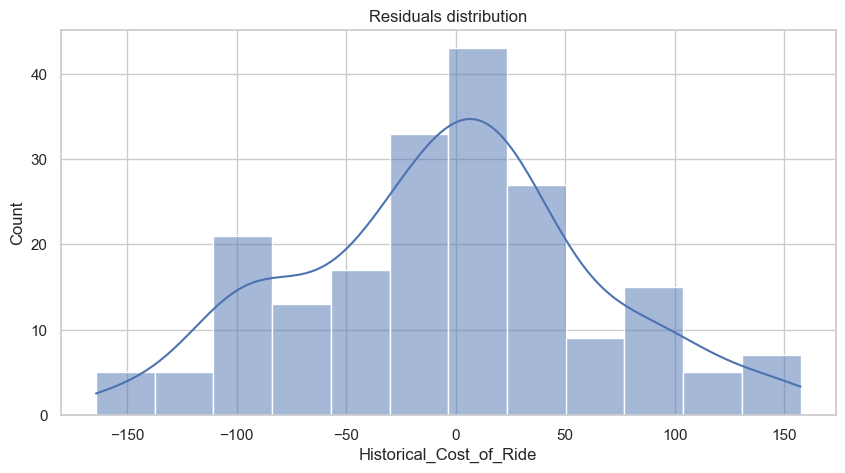

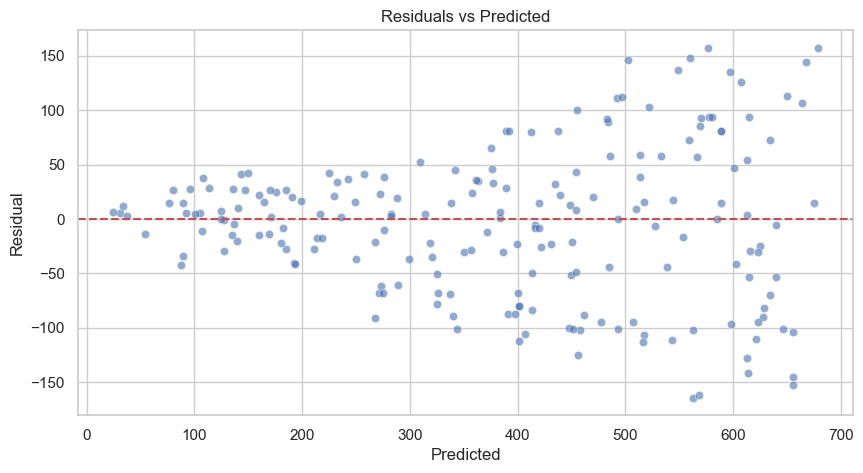

,feature,importance
4,Expected_Ride_Duration,0.883958
2,Number_of_Past_Rides,0.021430
3,Average_Ratings,0.020643
1,Number_of_Drivers,0.019613
0,Number_of_Riders,0.016743
15,Vehicle_Type_Economy,0.006310
16,Vehicle_Type_Premium,0.005932
7,Location_Category_Urban,0.003080
12,Time_of_Booking_Evening,0.002945
8,Customer_Loyalty_Status_Gold,0.002795


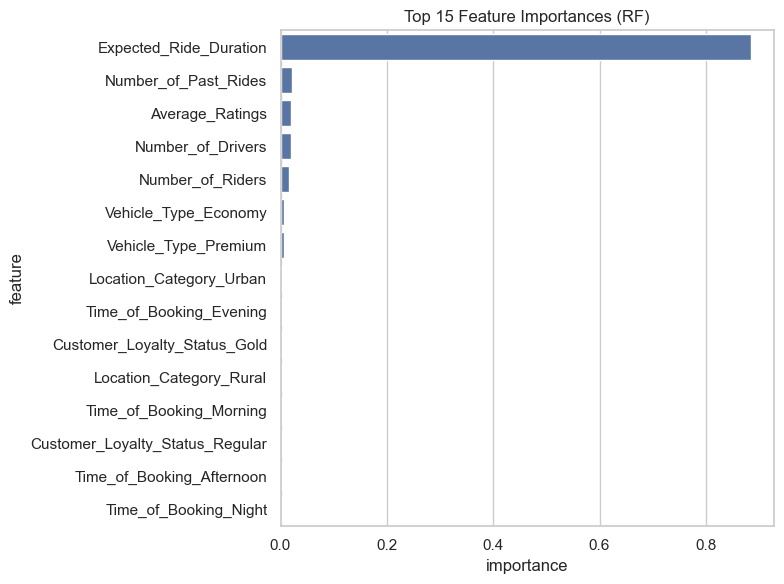

No 'units_sold' column found — revenue KPI skipped.
Saved models and preprocessors to C:\Users\D.Samhitha Franklin\Downloads\archive (7)\model_artifacts_no_pipeline
Target used: Historical_Cost_of_Ride
Top model: LinearRegression (RMSE=67.443, R²=0.875)


In [42]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = r"C:\Users\D.Samhitha Franklin\Downloads\archive (7)\dynamic_pricing.csv"
df = pd.read_csv(DATA_PATH)
display(df.head())
TARGET = "Historical_Cost_of_Ride"
if TARGET not in df.columns:
    raise KeyError(f"Target '{TARGET}' not found. Columns: {list(df.columns)}")

num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = [c for c in num_features if c != TARGET]
X = df.drop(columns=[TARGET])
y = df[TARGET].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
X_train_num = num_imputer.fit_transform(X_train[num_features])
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test[num_features])
X_test_num = scaler.transform(X_test_num)

cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_imputed = cat_imputer.fit_transform(X_train[cat_features])
X_test_cat_imputed = cat_imputer.transform(X_test[cat_features])

def make_onehot(**kwargs):
    try:
        return OneHotEncoder(**kwargs, sparse_output=False)
    except TypeError:
        return OneHotEncoder(**{k:v for k,v in kwargs.items() if k!='sparse_output'}, sparse=False)

ohe = make_onehot(handle_unknown="ignore")
if len(cat_features) > 0:
    X_train_cat_ohe = ohe.fit_transform(X_train_cat_imputed)
    X_test_cat_ohe = ohe.transform(X_test_cat_imputed)
else:
    X_train_cat_ohe = np.empty((X_train_num.shape[0],0))
    X_test_cat_ohe = np.empty((X_test_num.shape[0],0))

try:
    ohe_feature_names = list(ohe.get_feature_names_out(cat_features))
except Exception:
    ohe_feature_names = []
    for i, c in enumerate(cat_features):
        vals = pd.Series(X_train_cat_imputed[:, i]).astype(str).unique().tolist()
        for v in vals:
            ohe_feature_names.append(f"{c}__{v}")

feature_names = num_features + ohe_feature_names
X_train_pre = np.hstack([X_train_num, X_train_cat_ohe]) if X_train_cat_ohe.size else X_train_num
X_test_pre  = np.hstack([X_test_num,  X_test_cat_ohe])  if X_test_cat_ohe.size else X_test_num

X_train_pre_df = pd.DataFrame(X_train_pre, columns=feature_names)
X_test_pre_df  = pd.DataFrame(X_test_pre,  columns=feature_names)

lr = LinearRegression()
lr.fit(X_train_pre, y_train)
y_pred_lr = lr.predict(X_test_pre)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_pre, y_train)
y_pred_rf = rf.predict(X_test_pre)

def compute_kpis(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "mae": mae, "r2": r2}

lr_kpi = compute_kpis(y_test, y_pred_lr)
rf_kpi = compute_kpis(y_test, y_pred_rf)
kpi_df = pd.DataFrame([{"model":"LinearRegression", **lr_kpi}, {"model":"RandomForest", **rf_kpi}]).sort_values("rmse").reset_index(drop=True)
display(kpi_df)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.barplot(x='model', y='rmse', data=kpi_df)
plt.title("RMSE")
plt.subplot(1,3,2)
sns.barplot(x='model', y='mae', data=kpi_df)
plt.title("MAE")
plt.subplot(1,3,3)
sns.barplot(x='model', y='r2', data=kpi_df)
plt.title("R²")
plt.tight_layout()
plt.show()

best_model_name = kpi_df.loc[0,'model']
best_pred = y_pred_lr if best_model_name=="LinearRegression" else y_pred_rf
plt.figure()
sns.scatterplot(x=y_test, y=best_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted - {best_model_name}")
plt.tight_layout()
plt.show()

residuals = y_test - best_pred
plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")
plt.show()

plt.figure()
sns.scatterplot(x=best_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()

fi = rf.feature_importances_
if len(feature_names) == len(fi):
    feat_imp = pd.DataFrame({"feature": feature_names, "importance": fi}).sort_values("importance", ascending=False)
    display(feat_imp.head(15))
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
    plt.title("Top 15 Feature Importances (RF)")
    plt.tight_layout()
    plt.show()
else:
    raw_imp = pd.DataFrame({"importance": fi}).sort_values("importance", ascending=False).head(15)
    display(raw_imp)

if 'units_sold' in df.columns:
    test_idx = X_test.index
    test_data = X_test.copy()
    test_data['actual_price'] = y_test
    test_data['predicted_price'] = best_pred
    test_data['units_sold'] = df.loc[test_idx, 'units_sold']
    test_data['actual_revenue'] = test_data['actual_price'] * test_data['units_sold']
    test_data['predicted_revenue'] = test_data['predicted_price'] * test_data['units_sold']
    total_actual = test_data['actual_revenue'].sum()
    total_predicted = test_data['predicted_revenue'].sum()
    lift = (total_predicted - total_actual) / total_actual * 100 if total_actual != 0 else np.nan
    print(f"Total actual revenue: {total_actual:,.2f}")
    print(f"Total predicted revenue: {total_predicted:,.2f}")
    print(f"Revenue lift: {lift:.2f}%")
else:
    print("No 'units_sold' column found — revenue KPI skipped.")

out_dir = Path("model_artifacts_no_pipeline")
out_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(lr, out_dir / "linear_regression_model.joblib")
joblib.dump(rf, out_dir / "random_forest_model.joblib")
joblib.dump(num_imputer, out_dir / "numeric_imputer.joblib")
joblib.dump(scaler, out_dir / "scaler.joblib")
joblib.dump(cat_imputer, out_dir / "categorical_imputer.joblib")
joblib.dump(ohe, out_dir / "onehot_encoder.joblib")
kpi_df.to_csv(out_dir / "model_kpis.csv", index=False)
print(f"Saved models and preprocessors to {out_dir.resolve()}")

print("Target used:", TARGET)
print("Top model:", best_model_name, f"(RMSE={kpi_df.loc[0,'rmse']:.3f}, R²={kpi_df.loc[0,'r2']:.3f})")
if TARGET in num_features:
    corrs = df[num_features].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
    display(corrs.head(5))
